# **Part 1: Basic (Gaussian likelihood) GP regression model**

This section shows the different steps for creating and using a standard GP regression model, including:  
- reading and formatting data  
- choosing a kernel function  
- choosing a mean function (optional)  
- creating the model  
- viewing, getting, and setting model parameters  
- optimizing the model parameters  
- making predictions

We focus here on the implementation of the models in GPflow; for more intuition on these models, see [A Practical Guide to Gaussian Processes](https://drafts.distill.pub/gp/).

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow_probability import bijectors as tfb

import gpflow
from gpflow.utilities import print_summary
from gpflow.ci_utils import ci_niter, ci_range


%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 5)

# change the default format to notebook style:
gpflow.config.set_default_summary_fmt("notebook")

`X` and `Y` denote the input and output values. **NOTE:** `X` and `Y` must be two-dimensional NumPy arrays, $N \times 1$ or $N \times D$, where $D$ is the number of input dimensions/features, with the same number of rows as $N$ (one for each data point):


We will consider the following probabilistic model:

\begin{equation}
Y_i = f(X_i) + \varepsilon_i\,,  
\end{equation}

where $f \sim \mathcal{GP}(\mu(\cdot), k(\cdot, \cdot'))$, and $\varepsilon \sim \mathcal{N}(0, \tau^2 I)$.

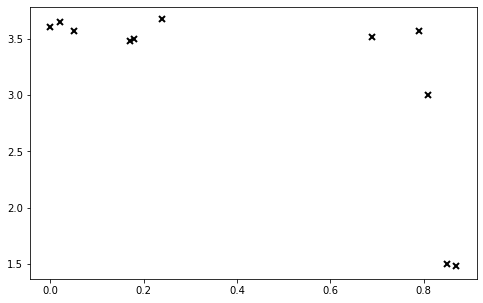

In [3]:
X = np.array([0, 0.02, 0.05, 0.17, 0.18, 0.24, 0.69, 0.79, 0.81, 0.85, 0.87]).reshape(-1,1)
Y = np.array([3.6, 3.65, 3.57, 3.48, 3.5, 3.67, 3.51, 3.57, 3.0, 1.5, 1.48]).reshape(-1,1)
plt.plot(X, Y, 'kx', mew=2);

## Choose a kernel

Several kernels (covariance functions) are implemented in GPflow. You can easily combine them to create new ones (see [Manipulating kernels](../advanced/kernels.ipynb)). You can also implement new covariance functions, as shown in the [Kernel design](../tailor/kernel_design.ipynb) notebook. Here, we will use a simple one:

In [4]:
k = gpflow.kernels.Matern52()

A summary of the kernel can be obtained by:

In [5]:
print_summary(k)

name,class,transform,prior,trainable,shape,dtype,value
Matern52.variance,Parameter,Softplus,,True,(),float64,1
Matern52.lengthscales,Parameter,Softplus,,True,(),float64,1


The Matern 5/2 kernel has two parameters: `lengthscales`, which encodes the "wiggliness" of the GP, and `variance`, which tunes the amplitude. They are both set to 1.0 as the default value. 


## Choose a mean function (optional)


It is common to choose $\mu = 0$, which is the GPflow default.

However, if there is a clear pattern (such as a mean value of `Y` that is far away from 0, or a linear trend in the data), mean functions can  be beneficial. Some simple ones are provided in the `gpflow.mean_functions` module.

Here's how to define a linear mean function:

`meanf = gpflow.mean_functions.Linear()`

## Construct a model


A GPflow model is created by instantiating one of the GPflow model classes, in this case GPR. We'll make a kernel `k` and instantiate a GPR object using the generated data and the kernel. We'll also set the variance of the likelihood to a sensible initial guess.


In [6]:
m = gpflow.models.GPR(data=(X, Y), kernel=k, mean_function=None)

A summary of the model can be obtained by


In [7]:
print_summary(m)

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,1
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,1
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1


The first two lines correspond to the kernel parameters, and the third one gives the likelihood parameter (the noise variance $\tau^2$ in our model).

You can access those values and manually set them to sensible initial guesses. For example:

In [8]:
m.likelihood.variance.assign(1)
m.kernel.lengthscales.assign(0.3)

<tf.Variable 'UnreadVariable' shape=() dtype=float64, numpy=-1.0502256128148466>

*R.Creel comment:*

*If you know that a kernel's hyperparameters have hard limits, you would want to set hard bounds.  For instance, if modeling the number of Metropolitan Opera audience members as a function of time, you would want bounds at 0 and 3800, the maximum capacity of the Met Opera House.*

*GPflow currently enforces hyperparameters to be positive but does not offer an option for bounds.*

*Until they do (i.e. I should submit a pull request), you can use this custom function to bound parameters.*   
`low` = lower bound;  
`param` = initialized value;  
`high` = upper bound. 

In [15]:
def bounded_parameter(low, param, high):
    """Make parameter tfp Parameter with optimization bounds."""

    sigmoid = tfb.Sigmoid(low=tf.cast(low, tf.float64), 
                          high=tf.cast(high, tf.float64),
                         name='sigmoid')
    parameter = gpflow.Parameter(param, transform=sigmoid, dtype=tf.float64)
    return parameter

In [16]:
k.lengthscales = bounded_parameter(0.2, 0.6, 1)
k.variance = bounded_parameter(0.1, 1, 10)

To obtain meaningful predictions, you need to tune the model parameters (that is, the parameters of the kernel, the likelihood, and the mean function if applicable) to the data at hand.

There are several optimizers available in GPflow. Here we use the `Scipy` optimizer, which by default implements the L-BFGS-B algorithm. (You can select other algorithms by using the `method=` keyword argument to its `minimize` method; see [the SciPy documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) for details of available options.)

In [17]:
opt = gpflow.optimizers.Scipy()

*R.Creel comment: If you instead wanted to use TensorFlow's implementation of the [Adam optimizer](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam), you would execute this code instead:*

In [10]:
# #specify epochs and learning rate
# iterations = ci_niter(500)
# learning_rate = 0.1

# #build Adam optimizer
# opt = tf.optimizers.Adam(learning_rate)

In order to train the model, we need to maximize the log marginal likelihood.
GPflow models define a `training_loss` that can be passed to the `minimize`
method of an optimizer; in this case it is simply the negative log marginal
likelihood. We also need to specify the variables to train with
m.trainable_variables`, and the number of iterations.

In [19]:
opt_logs = opt.minimize(m.training_loss,
                        m.trainable_variables,
                        options=dict(maxiter=100))

*R.Creel comment: To train a GPR model with Adam, we pass the GPR's `training_loss` training loss property to the `minimize` method just as we did above.*  

In [11]:
# epoch_print_freq = 100
# for i in range(iterations):
#     opt.minimize(m.training_loss, var_list=m.trainable_variables)
#     likelihood = m.log_marginal_likelihood()
#     if i % epoch_print_freq == 0:
#         tf.print(f"GPR with Adam: iteration {i + 1} likelihood {likelihood:.04f}")

GPR with Adam: iteration 1 likelihood -21.5342
GPR with Adam: iteration 101 likelihood -14.5151
GPR with Adam: iteration 201 likelihood -13.1152
GPR with Adam: iteration 301 likelihood -12.8198
GPR with Adam: iteration 401 likelihood -12.8130
GPR with Adam: iteration 501 likelihood -12.8120
GPR with Adam: iteration 601 likelihood -12.8119
GPR with Adam: iteration 701 likelihood -12.8119
GPR with Adam: iteration 801 likelihood -12.8119
GPR with Adam: iteration 901 likelihood -12.8119


In [12]:
print_summary(m)

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,7.66388
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.209426
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.0361041


Notice how the value column has changed.

The local optimum found by Maximum Likelihood might not be the one you want (for example, it might be overfitting or oversmooth). This depends on the initial values of the hyperparameters, and is specific to each dataset. As an alternative to Maximum Likelihood, [Markov Chain Monte Carlo (MCMC)](https://gpflow.readthedocs.io/en/master/notebooks/advanced/mcmc.html) is also available.

## Make predictions

We can now use the model to make some predictions at the new points `Xnew`. You might be interested in predicting two different quantities: the latent function values `f(Xnew)` (the denoised signal), or the values of new observations `y(Xnew)` (signal + noise). Because we are dealing with Gaussian probabilistic models, the predictions typically produce a mean and variance as output. Alternatively, you can obtain samples of `f(Xnew)` or the log density of the new data points `(Xnew, Ynew)`.

GPflow models have several prediction methods:


 - `m.predict_f` returns the mean and marginal variance of $f$ at the points `Xnew`.

 - `m.predict_f` with argument `full_cov=True` returns the mean and the full covariance matrix of $f$ at the points `Xnew`.

 - `m.predict_f_samples` returns samples of the latent function.

 - `m.predict_y` returns the mean and variance of a new data point (that is, it includes the noise variance).

 - `m.predict_log_density` returns the log density of the observations `Ynew` at `Xnew`.

We use `predict_f` and `predict_f_samples` to plot 95% confidence intervals and samples from the posterior distribution.

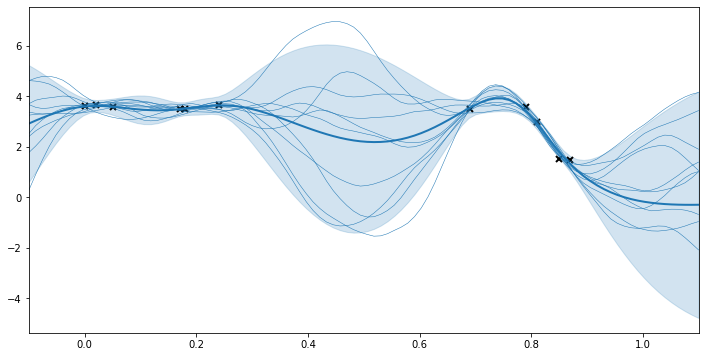

In [13]:
## generate test points for prediction
xx = np.linspace(-0.1, 1.1, 100).reshape(100, 1)  # test points must be of shape (N, D)

## predict mean and variance of latent GP at test points
mean, var = m.predict_f(xx)

## generate 10 samples from posterior
samples = m.predict_f_samples(xx, 10)  # shape (10, 100, 1)

## plot
def plot():
    plt.figure(figsize=(12, 6))
    plt.plot(X, Y, 'kx', mew=2)
    plt.plot(xx, mean, 'C0', lw=2)
    plt.fill_between(xx[:,0],
                     mean[:,0] - 1.96 * np.sqrt(var[:,0]),
                     mean[:,0] + 1.96 * np.sqrt(var[:,0]),
                     color='C0', alpha=0.2)

    plt.plot(xx, samples[:, :, 0].numpy().T, 'C0', linewidth=.5)
    plt.xlim(-0.1, 1.1);
    
plot()

## GP regression in higher dimensions


Very little changes when the input space has more than one dimension. By default, the `lengthscales` is an isotropic (scalar) parameter. It is generally recommended that you allow to tune a different lengthscale for each dimension (Automatic Relevance Determination, ARD): simply initialize `lengthscales` with an array of length $D$ corresponding to the input dimension of `X`.  See [Manipulating kernels](https://gpflow.readthedocs.io/en/master/notebooks/advanced/kernels.html) for further information.


**--------------------------------------------------------------------------------------**

# **Part 2: Manipulating Kernels**

GPflow comes with lots of standard kernels. Some very simple kernels produce constant functions, linear functions, and white noise functions:

 * `gpflow.kernels.Constant`

 * `gpflow.kernels.Linear`

 * `gpflow.kernels.White`

Some stationary functions produce samples with varying degrees of smoothness:

 * `gpflow.kernels.Exponential`

 * `gpflow.kernels.Matern12`

 * `gpflow.kernels.Matern32`

 * `gpflow.kernels.Matern52`

 * `gpflow.kernels.SquaredExponential` (also known as `gpflow.kernels.RBF`)

 * `gpflow.kernels.RationalQuadratic`

Two kernels produce periodic samples:

 * `gpflow.kernels.Cosine`

 * `gpflow.kernels.Periodic`

Other kernels that are implemented in core GPflow include:

 * `gpflow.kernels.Polynomial`

 * `gpflow.kernels.ArcCosine` ("neural network kernel")

 * `gpflow.kernels.Coregion`

 Let's define some plotting utils functions and have a look at samples from the prior for some of them:

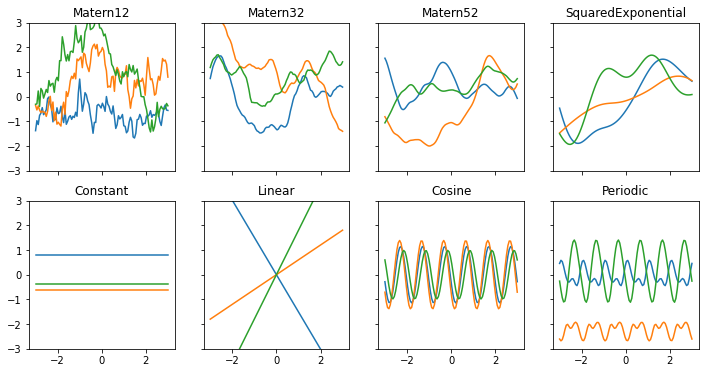

In [23]:
def plotkernelsample(k, ax, xmin=-3, xmax=3):
    xx = np.linspace(xmin, xmax, 100)[:, None]
    K = k(xx)
    ax.plot(xx, np.random.multivariate_normal(np.zeros(100), K, 3).T)
    ax.set_title(k.__class__.__name__)


np.random.seed(27)
f, axes = plt.subplots(2, 4, figsize=(12, 6), sharex=True, sharey=True)
plotkernelsample(gpflow.kernels.Matern12(), axes[0, 0])
plotkernelsample(gpflow.kernels.Matern32(), axes[0, 1])
plotkernelsample(gpflow.kernels.Matern52(), axes[0, 2])
plotkernelsample(gpflow.kernels.RBF(), axes[0, 3])
plotkernelsample(gpflow.kernels.Constant(), axes[1, 0])
plotkernelsample(gpflow.kernels.Linear(), axes[1, 1])
plotkernelsample(gpflow.kernels.Cosine(), axes[1, 2])
plotkernelsample(gpflow.kernels.Periodic(gpflow.kernels.SquaredExponential()), axes[1, 3])
_ = axes[0, 0].set_ylim(-3, 3)

In addition to changing the `lengthscale` and `variance` hyperparameters, as we did above, you can *call* the kernel object to compute covariance matrices:

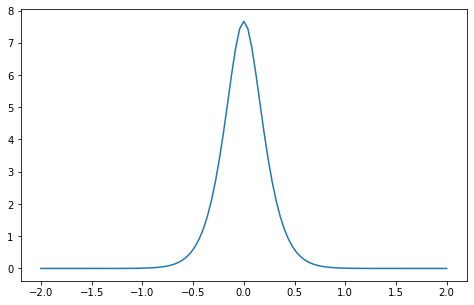

In [24]:
X1 = np.array([[0.0]])
X2 = np.linspace(-2, 2, 101).reshape(-1, 1)

K21 = k(X2, X1)  # cov(f(X2), f(X1)): matrix with shape [101, 1]
K22 = k(X2)  # equivalent to k(X2, X2) (but more efficient): matrix with shape [101, 101]

#plotting
plt.figure()
_ = plt.plot(X2, K21)

# Combine kernels


Sums and products of kernels are also valid kernels. You can add or multiply instances of kernels to create a new composite kernel with the parameters of the old ones:



name,class,transform,prior,trainable,shape,dtype,value
Sum.kernels[0].variance,Parameter,Softplus,,True,(),float64,1
Sum.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,1
Sum.kernels[1].variance,Parameter,Softplus,,True,(),float64,1


name,class,transform,prior,trainable,shape,dtype,value
Product.kernels[0].variance,Parameter,Softplus,,True,(),float64,1
Product.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,1
Product.kernels[1].variance,Parameter,Softplus,,True,(),float64,1


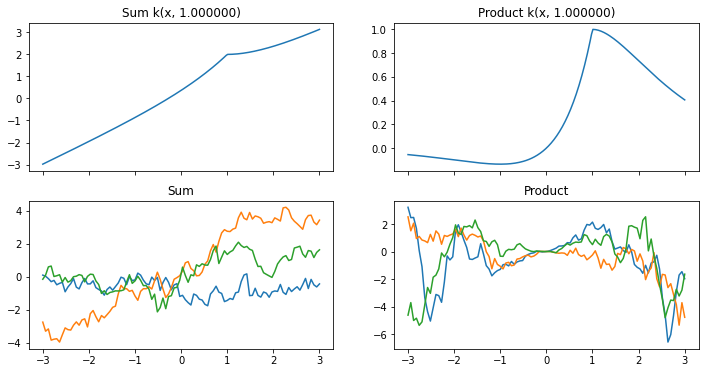

In [25]:
k1 = gpflow.kernels.Matern12()
k2 = gpflow.kernels.Linear()

k3 = k1 + k2
k4 = k1 * k2

print_summary(k3)
print_summary(k4)


def plotkernelfunction(k, ax, xmin=-3, xmax=3, other=0):
    xx = np.linspace(xmin, xmax, 200)[:, None]
    ax.plot(xx, k(xx, np.zeros((1, 1)) + other))
    ax.set_title(k.__class__.__name__ + " k(x, %f)" % other)


f, axes = plt.subplots(2, 2, figsize=(12, 6), sharex=True)
plotkernelfunction(k3, axes[0, 0], other=1.0)
plotkernelfunction(k4, axes[0, 1], other=1.0)
plotkernelsample(k3, axes[1, 0])
plotkernelsample(k4, axes[1, 1])

# Kernels for higher-dimensional input spaces

Kernels generalize to multiple dimensions straightforwardly. Stationary kernels support "Automatic Relevance Determination" (ARD), that is, having a different lengthscale parameter for each input dimension. Simply pass in an array of the same length as the number of input dimensions. **NOTE:** This means that the kernel object is then able to process only inputs of that dimension!


You can also initialize the lengthscales when the object is created:

In [26]:
k = gpflow.kernels.Matern52(lengthscales=[0.1, 0.2, 5.0])
print_summary(k)

name,class,transform,prior,trainable,shape,dtype,value
Matern52.variance,Parameter,Softplus,,True,(),float64,1.0
Matern52.lengthscales,Parameter,Softplus,,True,"(3,)",float64,[0.1 0.2 5. ]


# Specify active dimensions


When combining kernels, it’s often helpful to have bits of the kernel working on different dimensions. For example, to model a function that is linear in the first dimension and smooth in the second, we could use a combination of Linear and Matern52 kernels, one for each dimension.



To tell GPflow which dimension a kernel applies to, specify a list of integers as the value of the `active_dims` parameter.

In [27]:
k1 = gpflow.kernels.Linear(active_dims=[0])
k2 = gpflow.kernels.Matern52(active_dims=[1])
k = k1 + k2

`active_dims` makes it easy to create additive models. Here we build an additive Matern 5/2 kernel:


In [28]:
k = gpflow.kernels.Matern52(active_dims=[0], lengthscales=2) + gpflow.kernels.Matern52(
    active_dims=[1], lengthscales=2
)

Let's plot this kernel and sample from it:

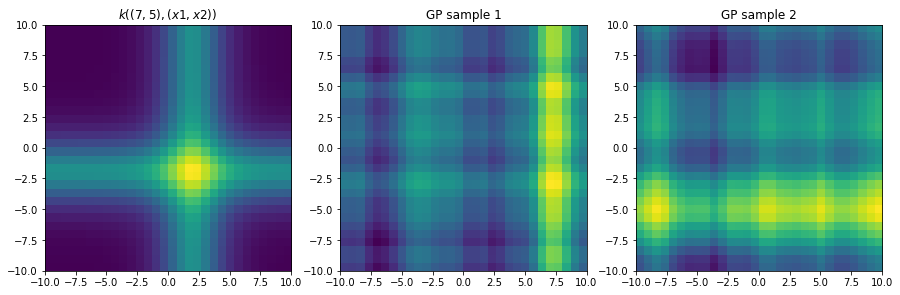

In [29]:
n_grid = 30
x = np.linspace(-10, 10, n_grid)
X, Y = np.meshgrid(x, x)
X = np.vstack((X.flatten(), Y.flatten())).T

x0 = np.array([[2.0, 2.0]])
# plot the kernel
KxX = k(X, x0).numpy().reshape(n_grid, n_grid)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(KxX, extent=[-10, 10, -10, 10])
axes[0].set_title(f"$k((7, 5), (x1, x2))$")

# plot a GP sample
K = k(X).numpy()
Z = np.random.multivariate_normal(np.zeros(n_grid ** 2), K, 2)
axes[1].imshow(Z[0, :].reshape(n_grid, n_grid), extent=[-10, 10, -10, 10])
axes[1].set_title("GP sample 1")
axes[2].imshow(Z[1, :].reshape(n_grid, n_grid), extent=[-10, 10, -10, 10])
_ = axes[2].set_title("GP sample 2")

# **Part 3: (MCMC) Markov Chain Monte Carlo**

GPflow allows you to approximate the posterior over the latent functions of its models (and over the hyperparemeters after setting a prior for those) using Hamiltonian Monte Carlo (HMC).



*R.Creel Comment:*

*The Hamiltonian Monte Carlo is an instance of the Metropolis-Hastings algorithm, which iteratively choses samples from a desired distribution P(x) in order to approximate that distribution.  At each iteration, the algorithm picks a candidate for the next sample value based only on the current sample value (i.e. it is a Markov chain).*  

*Then, with some probability, the candidate value is either accepted, to be used in the next iteration, or rejected, in which case the candidate is discarded and current value is reused in the next iteration.  The probability of acceptance is determined by comparing the values of the function f(x) of the current and candidate sample values with respect to the desired distribution P(x).*

*GPR requires the assumption of normal distributions on all data distributions  -- often a poor assumption.  MCMC allows us to model non-normal distributions, but is not analytic*

In [30]:
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd

from gpflow import set_trainable
from multiclass import plot_from_samples

gpflow.config.set_default_float(np.float64)
gpflow.config.set_default_jitter(1e-4)
# convert to float64 for tfp to play nicely with gpflow in 64
f64 = gpflow.utilities.to_default_float

tf.random.set_seed(123)
colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]

We first consider the GP regression (with Gaussian noise) for which the marginal likelihood $p(\mathbf y\,|\,\theta)$ can be computed exactly.

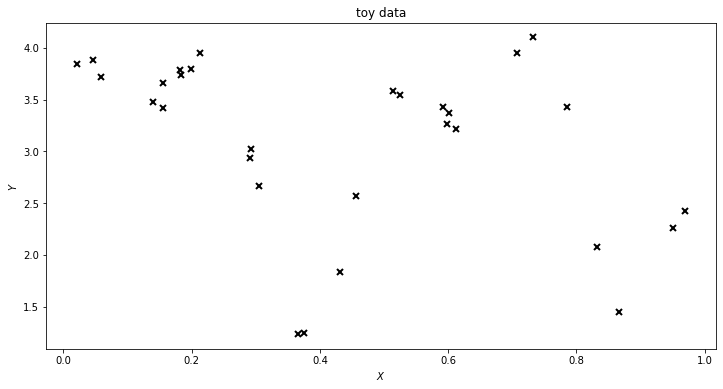

In [31]:
rng = np.random.RandomState(42)

N = 30


def synthetic_data(num: int, rng: np.random.RandomState):
    X = rng.rand(num, 1)
    Y = np.sin(12 * X) + 0.66 * np.cos(25 * X) + rng.randn(num, 1) * 0.1 + 3
    return X, Y


data = (X, Y) = synthetic_data(N, rng)

plt.figure(figsize=(12, 6))
plt.plot(X, Y, "kx", mew=2)
plt.xlabel("$X$")
plt.ylabel("$Y$")
plt.title("toy data")
plt.show()

## MCMC for hyperparameters $\theta$

We now want to sample from the posterior over $\theta$:
\begin{equation}
p(\theta|\mathbf{y}) \propto p(\mathbf{y}|\theta)p(\theta)
\end{equation}

Firstly, we build the GPR model.

In [32]:
kernel = gpflow.kernels.Matern52(lengthscales=0.3)
mean_function = gpflow.mean_functions.Linear(1.0, 0.0)
model = gpflow.models.GPR(data, kernel, mean_function, noise_variance=0.01)

Secondly, we initialize the model to the maximum likelihood solution.

In [33]:
optimizer = gpflow.optimizers.Scipy()
optimizer.minimize(model.training_loss, model.trainable_variables)

print(f"log posterior density at optimum: {model.log_posterior_density()}")

log posterior density at optimum: -2.4371366970694623


Thirdly, we add priors to the hyperparameters.



In [34]:
# tfp.distributions dtype is inferred from parameters - so convert to 64-bit
model.kernel.lengthscales.prior = tfd.Gamma(f64(1.0), f64(1.0))
model.kernel.variance.prior = tfd.Gamma(f64(1.0), f64(1.0))
model.likelihood.variance.prior = tfd.Gamma(f64(1.0), f64(1.0))
model.mean_function.A.prior = tfd.Normal(f64(0.0), f64(10.0))
model.mean_function.b.prior = tfd.Normal(f64(0.0), f64(10.0))

gpflow.utilities.print_summary(model)

name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.A,Parameter,,Normal,True,"(1, 1)",float64,[[-1.06377032]]
GPR.mean_function.b,Parameter,,Normal,True,(),float64,3.5474603444022423
GPR.kernel.variance,Parameter,Softplus,Gamma,True,(),float64,0.9357531803027443
GPR.kernel.lengthscales,Parameter,Softplus,Gamma,True,(),float64,0.1039023714210819
GPR.likelihood.variance,Parameter,Softplus + Shift,Gamma,True,(),float64,0.005756764054343774


We now sample from the posterior using HMC.


In [35]:
num_burnin_steps = ci_niter(300)
num_samples = ci_niter(500)

# Note that here we need model.trainable_parameters, not trainable_variables - only parameters can have priors!
hmc_helper = gpflow.optimizers.SamplingHelper(
    model.log_posterior_density, model.trainable_parameters
)

hmc = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=hmc_helper.target_log_prob_fn, num_leapfrog_steps=10, step_size=0.01
)
adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
    hmc, num_adaptation_steps=10, target_accept_prob=f64(0.75), adaptation_rate=0.1
)


@tf.function
def run_chain_fn():
    return tfp.mcmc.sample_chain(
        num_results=num_samples,
        num_burnin_steps=num_burnin_steps,
        current_state=hmc_helper.current_state,
        kernel=adaptive_hmc,
        trace_fn=lambda _, pkr: pkr.inner_results.is_accepted,
    )


samples, traces = run_chain_fn()
parameter_samples = hmc_helper.convert_to_constrained_values(samples)

param_to_name = {param: name for name, param in gpflow.utilities.parameter_dict(model).items()}

**NOTE:** All the Hamiltonian MCMC sampling takes place in an unconstrained space (where constrained parameters have been mapped via a bijector to an unconstrained space). This makes the optimization, as required in the gradient step, much easier.

However, we often wish to sample the constrained parameter values, not the unconstrained one. The `SamplingHelper` helps us convert our unconstrained values to constrained parameter ones.


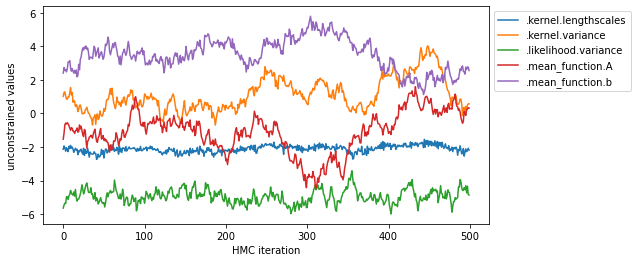

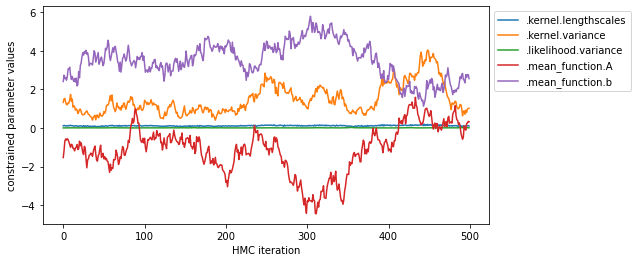

In [36]:
def plot_samples(samples, parameters, y_axis_label):
    plt.figure(figsize=(8, 4))
    for val, param in zip(samples, parameters):
        plt.plot(tf.squeeze(val), label=param_to_name[param])
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.xlabel("HMC iteration")
    plt.ylabel(y_axis_label)


plot_samples(samples, model.trainable_parameters, "unconstrained values")
plot_samples(parameter_samples, model.trainable_parameters, "constrained parameter values")

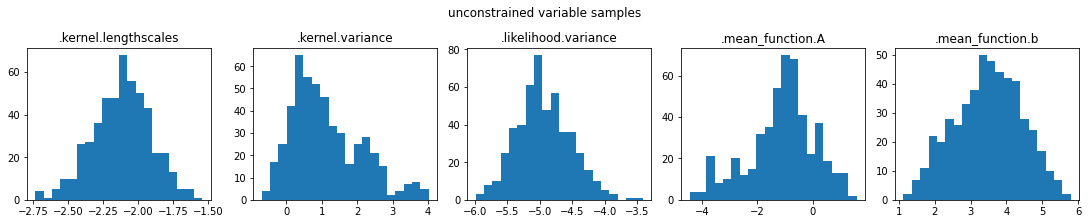

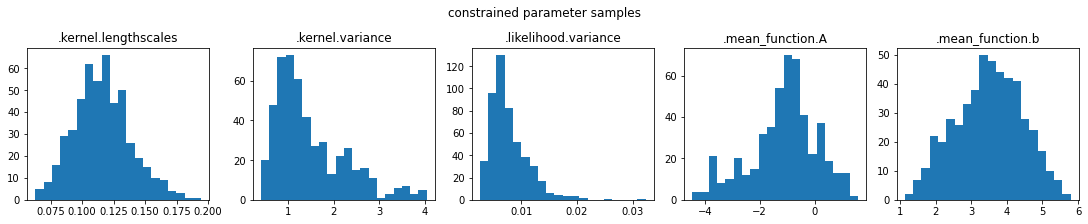

In [37]:
def marginal_samples(samples, parameters, y_axis_label):
    fig, axes = plt.subplots(1, len(param_to_name), figsize=(15, 3), constrained_layout=True)
    for ax, val, param in zip(axes, samples, parameters):
        ax.hist(np.stack(val).flatten(), bins=20)
        ax.set_title(param_to_name[param])
    fig.suptitle(y_axis_label)
    plt.show()


marginal_samples(samples, model.trainable_parameters, "unconstrained variable samples")
marginal_samples(parameter_samples, model.trainable_parameters, "constrained parameter samples")

**NOTE:** The sampler runs in unconstrained space (so that positive parameters remain positive, and parameters that are not trainable are ignored).

For serious analysis you most certainly want to run the sampler longer, with multiple chains and convergence checks. This will do for illustration though!


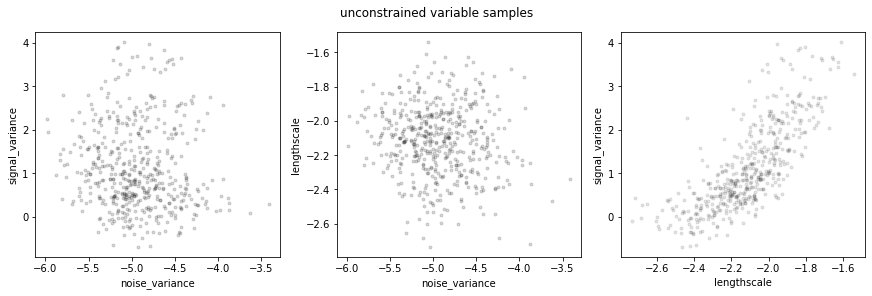

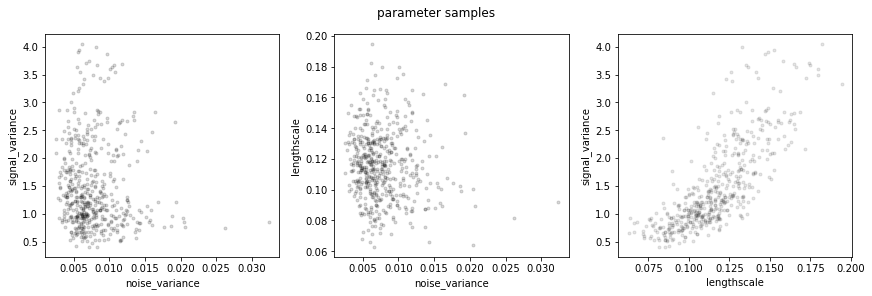

In [38]:
def plot_joint_marginals(samples, parameters, y_axis_label):
    name_to_index = {param_to_name[param]: i for i, param in enumerate(parameters)}
    f, axs = plt.subplots(1, 3, figsize=(12, 4), constrained_layout=True)

    axs[0].plot(
        samples[name_to_index[".likelihood.variance"]],
        samples[name_to_index[".kernel.variance"]],
        "k.",
        alpha=0.15,
    )
    axs[0].set_xlabel("noise_variance")
    axs[0].set_ylabel("signal_variance")

    axs[1].plot(
        samples[name_to_index[".likelihood.variance"]],
        samples[name_to_index[".kernel.lengthscales"]],
        "k.",
        alpha=0.15,
    )
    axs[1].set_xlabel("noise_variance")
    axs[1].set_ylabel("lengthscale")

    axs[2].plot(
        samples[name_to_index[".kernel.lengthscales"]],
        samples[name_to_index[".kernel.variance"]],
        "k.",
        alpha=0.1,
    )
    axs[2].set_xlabel("lengthscale")
    axs[2].set_ylabel("signal_variance")
    f.suptitle(y_axis_label)
    plt.show()


plot_joint_marginals(samples, model.trainable_parameters, "unconstrained variable samples")
plot_joint_marginals(parameter_samples, model.trainable_parameters, "parameter samples")


To plot the posterior of predictions, we’ll iterate through the samples and set the model state with each sample. Then, for that state (set of hyperparameters) we’ll draw some samples from the prediction function.

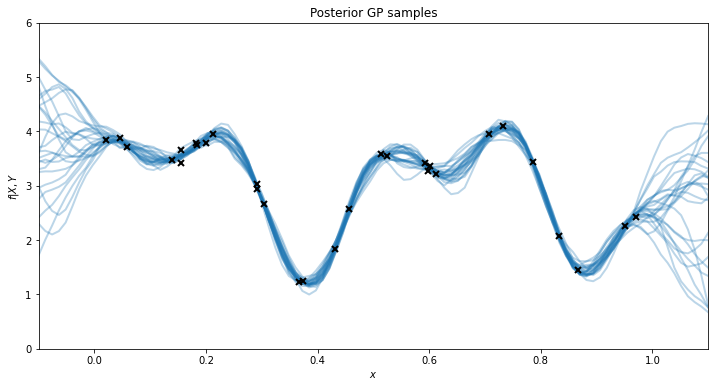

In [39]:
# plot the function posterior
xx = np.linspace(-0.1, 1.1, 100)[:, None]
plt.figure(figsize=(12, 6))

for i in range(0, num_samples, 20):
    for var, var_samples in zip(hmc_helper.current_state, samples):
        var.assign(var_samples[i])
    f = model.predict_f_samples(xx, 1)
    plt.plot(xx, f[0, :, :], "C0", lw=2, alpha=0.3)

plt.plot(X, Y, "kx", mew=2)
_ = plt.xlim(xx.min(), xx.max())
_ = plt.ylim(0, 6)
plt.xlabel("$x$")
plt.ylabel("$f|X,Y$")
plt.title("Posterior GP samples")

plt.show()